In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from ase.build import bulk
from ase.io import write

In [4]:
from adis_tools.parsers import parse_pw

# Functions

In [5]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'CONTROL': {
                'calculation': input_dict["calculation"],
            },
            'SYSTEM': {
                'occupations': 'smearing',
                'degauss': input_dict["smearing"],
            }
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [6]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, 'pwscf.xml'))
    return {
        "structure": output['ase_structure'],
        "energy": output["energy"],
        "volume": output['ase_structure'].get_volume(),
    }

In [7]:
def workflow(project, structure): 
    # Structure optimization 
    job_qe_minimize = pr.create.job.QEJob(job_name="qe_relax")
    job_qe_minimize.input["calculation"] = "vc-relax"
    job_qe_minimize.input.structure = structure
    job_qe_minimize.run()
    structure_opt = job_qe_minimize.output.structure

    # Energy Volume Curve 
    energy_lst, volume_lst = [], []
    for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
        structure_strain = structure_opt.copy()
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain**(1/3), 
            scale_atoms=True
        )
        job_strain = pr.create.job.QEJob(
            job_name="job_strain_" + str(i)
        )
        job_strain.input.structure = structure_strain
        job_strain.run(delete_existing_job=True)
        energy_lst.append(job_strain.output.energy)
        volume_lst.append(job_strain.output.volume)
    
    return {"volume": volume_lst, "energy": energy_lst}

# Setup

In [8]:
from pyiron_base import Project

In [9]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

In [10]:
pr.create_job_class(
    class_name="QEJob",
    write_input_funct=write_input,
    collect_output_funct=collect_output,
    default_input_dict={  # Default Parameter 
        "structure": None, 
        "pseudopotentials": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, 
        "kpts": (3, 3, 3),
        "calculation": "scf",
        "smearing": 0.02,
    },
    executable_str="mpirun -np 1 pw.x -in input.pwi > output.pwo",
)

# Workflow

In [11]:
job_workflow = pr.wrap_python_function(workflow)
job_workflow.input.project = pr
job_workflow.input.structure = bulk('Al', a=4.05, cubic=True)
job_workflow.run()

The job workflowbc8cc7fbdf2b9679971e2ab088ec08f0 was saved and received the ID: 1
The job qe_relax was saved and received the ID: 2
The job job_strain_0 was saved and received the ID: 3
The job job_strain_1 was saved and received the ID: 4
The job job_strain_2 was saved and received the ID: 5
The job job_strain_3 was saved and received the ID: 6
The job job_strain_4 was saved and received the ID: 7


# Result

Text(0, 0.5, 'Energy')

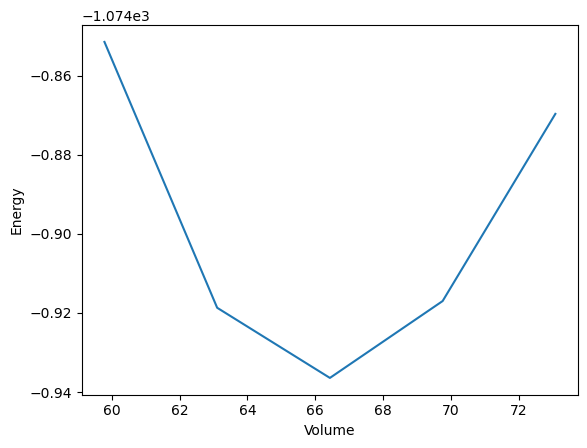

In [12]:
plt.plot(job_workflow.output.result["volume"], job_workflow.output.result["energy"])
plt.xlabel("Volume")
plt.ylabel("Energy")

# Summary

In [13]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,workflowbc8cc7fbdf2b9679971e2ab088ec08f0,/workflowbc8cc7fbdf2b9679971e2ab088ec08f0,None,/home/jovyan/test/,2024-01-24 06:03:18.553844,NaT,NaN,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,PythonFunctionContainerJob,0.4,None,None
1,2,finished,None,qe_relax,/qe_relax,None,/home/jovyan/test/,2024-01-24 06:03:18.630590,2024-01-24 06:04:03.197788,44.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
2,3,finished,None,job_strain_0,/job_strain_0,None,/home/jovyan/test/,2024-01-24 06:04:03.263535,2024-01-24 06:04:12.664081,9.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
3,4,finished,None,job_strain_1,/job_strain_1,None,/home/jovyan/test/,2024-01-24 06:04:12.731601,2024-01-24 06:04:22.509220,9.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
4,5,finished,None,job_strain_2,/job_strain_2,None,/home/jovyan/test/,2024-01-24 06:04:22.574489,2024-01-24 06:04:31.983411,9.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
5,6,finished,None,job_strain_3,/job_strain_3,None,/home/jovyan/test/,2024-01-24 06:04:32.051614,2024-01-24 06:04:42.094761,10.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
6,7,finished,None,job_strain_4,/job_strain_4,None,/home/jovyan/test/,2024-01-24 06:04:42.159023,2024-01-24 06:04:52.249084,10.0,pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2dah2dtdos#1,ExecutableContainerJob,0.4,None,None
